In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit

# Upload the data

In [2]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)

delays = pd.read_csv('partners_delays.csv')
delays = delays.rename(columns={'dttm': 'date'})
delays.date = pd.to_datetime(delays.date)

forecast = pd.read_csv('orders-forecasted.csv')

# Data preprocessing

In [3]:
df_train = orders[(orders.date >= pd.to_datetime('2021-11-08')) & (orders.date < pd.to_datetime('2021-12-01'))]
df_train_const = df_train.groupby(by='delivery_area_id', as_index=False).mean()
df_train_const = df_train_const[df_train_const.orders_cnt >= 10]

delays = delays[(delays.date >= pd.to_datetime('2021-11-08')) & (delays.date < pd.to_datetime('2021-12-01'))]
delays = delays[delays.delivery_area_id.isin(df_train_const.delivery_area_id)]
orders = orders[(orders.date >= pd.to_datetime('2021-11-08')) & (orders.date < pd.to_datetime('2021-12-01'))]
orders = orders[orders.delivery_area_id.isin(df_train_const.delivery_area_id)]


df = orders.join(delays.set_index(['delivery_area_id', 'date']), 
                 on=['delivery_area_id', 'date'], 
                 how='inner')

timetable = df.groupby(by=['delivery_area_id'], as_index=False).mean()

# Dependency of delay rate analysis

X-axis intersection: 0.8474004520951727


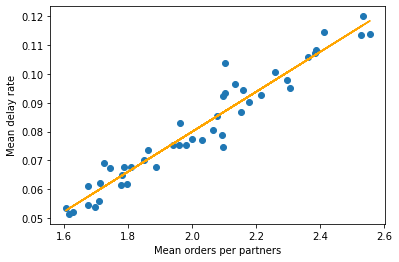

In [4]:
def linear(x, a, b): return a*x + b

x, y = timetable.orders_cnt/timetable.partners_cnt, timetable.delay_rate

popt, pcov = curve_fit(linear, x, y)

plt.scatter(x, y)
plt.plot(x, linear(x, *popt), c='orange')
plt.xlabel('Mean orders per partners')
plt.ylabel('Mean delay rate')

a, b = popt
print('X-axis intersection:', -b/a)

# Timetable optimization

In [5]:
timetable_optimized = pd.DataFrame(forecast)
timetable_optimized['partners_cnt'] = (-a/b)*timetable_optimized.orders_cnt
timetable_optimized.head()

,delivery_area_id,date,orders_cnt,partners_cnt
0,0,2021-12-01 10:00:00,15,17.701194
1,0,2021-12-01 11:00:00,10,11.800796
2,0,2021-12-01 12:00:00,7,8.260557
3,0,2021-12-01 13:00:00,11,12.980876
4,0,2021-12-01 14:00:00,10,11.800796


In [6]:
timetable_optimized = timetable_optimized.drop(columns='orders_cnt')
timetable_optimized.partners_cnt = timetable_optimized.partners_cnt.apply(int)
timetable_optimized

,delivery_area_id,date,partners_cnt
0,0,2021-12-01 10:00:00,17
1,0,2021-12-01 11:00:00,11
2,0,2021-12-01 12:00:00,8
3,0,2021-12-01 13:00:00,12
4,0,2021-12-01 14:00:00,11
...,...,...,...
4008,516,2021-12-07 17:00:00,11
4009,516,2021-12-07 18:00:00,14
4010,516,2021-12-07 19:00:00,15
4011,516,2021-12-07 20:00:00,15


In [7]:
timetable_optimized.to_csv('timetable_optimized.csv')